# Task 2: Quantum Errors - Bit Flip and Phase Flip

In [1]:
# Importing the necessary Modules
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

%matplotlib inline

## Part 2.1: Circuit to Generate the Bell State  

Creating the following bell state using the given quantum circuit:  

$$\left|\Psi\right\rangle = \frac{\left|00\right\rangle + \left|11\right\rangle}{\sqrt2}$$

1. The Hadamard gate creates a superposition state
2. The Controlled Not gate entangles the two qubits

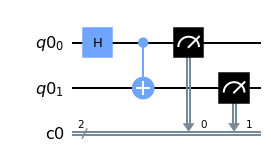

In [2]:
# initialize the circuit with two Classical and Quantum Bits
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

# Creating the Bell State
circuit.h(qr[0])
circuit.cx(qr[0], qr[1])

# Measuring the two qubits
circuit.measure(qr, cr)
circuit.draw(output='mpl')

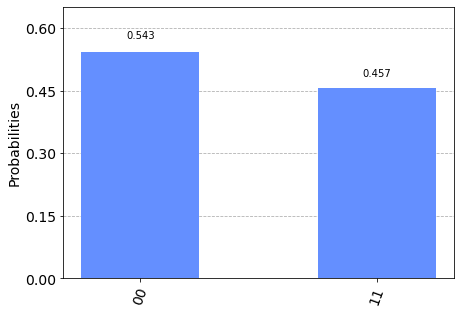

In [3]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(circuit))

The results after measuring the two qubits of the bell state $|\psi\rangle$ gives us the expexted results of the states $|00\rangle$ and $|11\rangle$ with a probability of about about 50% for each.

The states $|01\rangle$ and $|10\rangle$ are not obtained when the gates are ideal with no noise present in the circuit.

## Part 2.2: Introducing Error before the CNOT gate

This part requires us to indroduce an "Error Gate" just before the C-NOT gate. The "Error Gate" performs a Phase Flip (Z Gate) with probability p1 and Bit Flip (X Gate) with probabitlity p2.  

I have implemented this random "Error Gate" using non-ideal(noisy) Identity gates just before the C-NOT gate. To simulate the noisy Identity Gate, I've used the NoiseModel class provided in qiskit Aer.

The Identity Gate in addition to the Identity operation introduces an error by either flipping the phase or flipping the bit with some non zero probabilities.

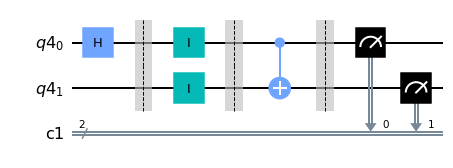

In [4]:
# initialize circuit with Classical and Quantum Bits
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.barrier()

# "Error Gate" implemented by a noisy Identity gate
circuit.id(qr[:])
circuit.barrier()

circuit.cx(qr[0], qr[1])
circuit.barrier()

circuit.measure(qr, cr)

circuit.draw(output='mpl')

Noise Model on the Identity gate:
 - X with Probability = bit_flip_prob
 - Z with Probability = phase_flip_prob
 - I with Probability = 1 - bit_flip_prob - phase_flip_prob

In [5]:
def noise_model(phase_flip_prob, bit_flip_prob):
    '''
    phase_flip_prob: Probability of a phase flip occuring
    bit_flip_prob: Probability of a bit flip occuring
    '''

    # Defining the types of error and the probabilities with which they can occur in a particular gate
    error_gate = pauli_error([('X', bit_flip_prob), ('Z', phase_flip_prob), ('I', 1 - bit_flip_prob - phase_flip_prob)])

    # Creating a noise_model object
    noise_model = NoiseModel()
    
    # Adding noise to the Identity to simulate noise between two gates(channel noise)
    noise_model.add_all_qubit_quantum_error(error_gate, ["id"])
    
    return noise_model

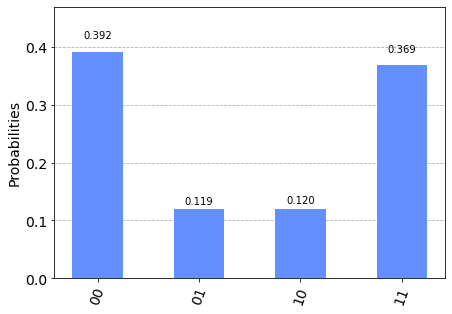

In [6]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
phase_bit_flip = noise_model(phase_flip_prob = 0.25, bit_flip_prob = 0.25)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(circuit))

As we can see here, the measurement results obtained include the terms $|01\rangle$ and $|10\rangle$ apart from the terms corresponding to the Bell state. The noise between the Hadamard gate and the C-NOT gate have resulted in non-zero probabilities for obtaining the states $|01\rangle$ and $|10\rangle$.  

The states $|00\rangle$ and $|11\rangle$ are obtained with equal probabilitites and their probabilities are large compared to the probabilites for obtaining the $|01\rangle$ and $|10\rangle$ states.

## Part 2.3: Quantum Error Correction

Let us analyze the tranformation of the input state across circuit. For convenience in understanding the evolution of the state across the circuit, let the state at each barrier be represented as $|\psi_i\rangle$ where $i$ is the barrier number from the left of the circuit. 

**Input state:** $|\psi_0\rangle = |00\rangle$  

**State at the 1st Barrier:** $|\psi_1\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}\otimes|0\rangle$  

**State at the 2nd Barrier:** $|\psi_2\rangle = \frac{E_1|0\rangle + E_1|1\rangle}{\sqrt{2}}\otimes E_2|0\rangle$  

In the state $|\psi_2\rangle$, $E_1$ and $E_2$ are error gates that have a non-zero probability of either performing a bit flip or a phase flip operation.

From $|\psi_2\rangle$, we obtain some important information about the effect of the Error Gates.


**Upper Qubit:**
The upper qubit is in the state $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. The $X$ gate does not introduce any change in this qubit. Hence, the Error Gate $E_1$ can only introduce a phase flip error with a probability `p1 = phase_flip_error` and no change with a probability `p2 = (1 - phase_flip_error)`. 

$|\phi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$   

Action of the $X$ gate gives us the same state,  
$X|\phi\rangle = \frac{1}{\sqrt{2}}(X|0\rangle + X|1\rangle)  
               = \frac{1}{\sqrt{2}}(|1\rangle + |0\rangle)$

To correct the error, we need to only implement a phase flip code.


**Lower Qubit:**
The lower qubit is in the state $|0\rangle$. The $Z$ gate does not introduce any change in this qubit. Hence, the Error Gate $E_2$ can only introduce a bit flip error with a probability `p1 = phase_flip_error` and no change with a probability `p2 = (1 - phase_flip_error)`. 

$|\phi\rangle = |0\rangle$   

Action of the $Z$ gate gives us the same state,  
$Z|\phi\rangle = Z|0\rangle  
               = |0\rangle$

To correct the error, we need to only implement a bit flip code.

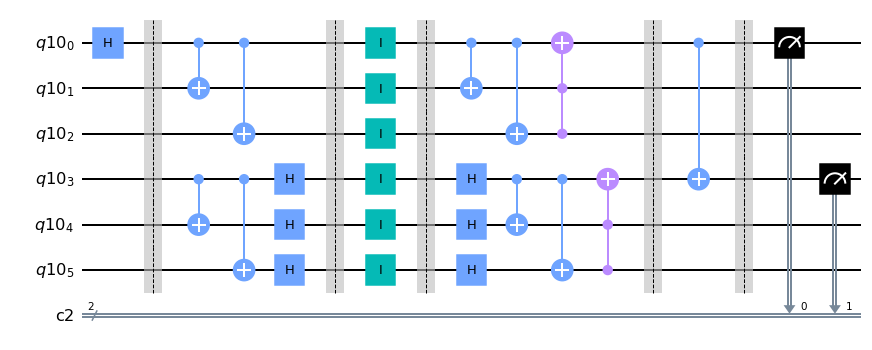

In [7]:
# initialize circuit with Classical and Quantum Bits
qr = QuantumRegister(6)
cr = ClassicalRegister(2)

code = QuantumCircuit(qr, cr)

code.h(qr[0])
code.barrier()

# C-NOT Gates for the bit flip code
code.cx(qr[0], qr[1])
code.cx(qr[0], qr[2])
code.cx(qr[3], qr[4])
code.cx(qr[3], qr[5])
code.h(qr[3:6])

code.barrier()

# Non-Ideal Identity Gates
code.id(qr[:])

code.barrier()

# C-NOT Gates for the Bit Flip Code
code.cx(qr[0], qr[1])
code.cx(qr[0], qr[2])
code.ccx(qr[1], qr[2], qr[0])
code.h(qr[3:6])
code.cx(qr[3], qr[4])
code.cx(qr[3], qr[5])
code.ccx(qr[4], qr[5], qr[3])

code.barrier()

code.cx(qr[0], qr[3])

code.barrier()

code.measure([qr[0], qr[3]], cr)

code.draw(output='mpl')

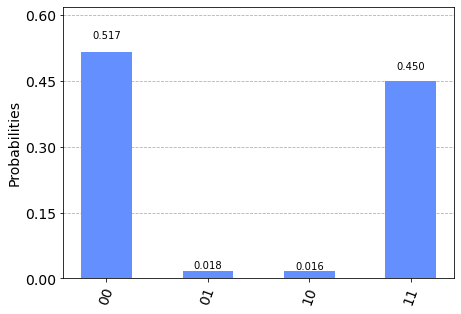

In [8]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
bit_flip_error = noise_model(phase_flip_prob = 0.1, bit_flip_prob = 0.1)
result = execute(code, backend = simulator, noise_model = bit_flip_error).result()

# Plotting the Simulation results
plot_histogram(result.get_counts(code))

We can infer from the above histogram that the above Quantum Error Correcting Code does reduce the probaility of obtaining the wrong results from the circuit.

## Part 2.4: Comparision of the Code's Performace with the Results of the Circuit without any Correction Code

### Test Case 1:
**Bit Flip - 1%**  
**Phase Flip - 1%**

Vanilla Circuit without Error Correction


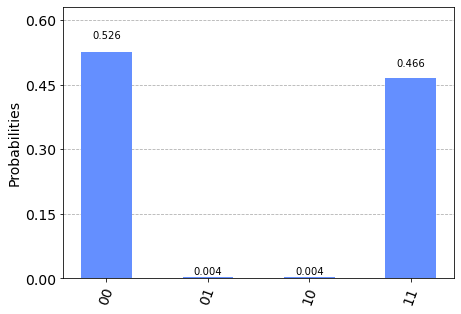

In [9]:
# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
phase_bit_flip = noise_model(phase_flip_prob = 0.01, bit_flip_prob = 0.01)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Vanilla Circuit without Error Correction")
plot_histogram(result.get_counts(circuit))

Circuit with Error Correcting Code


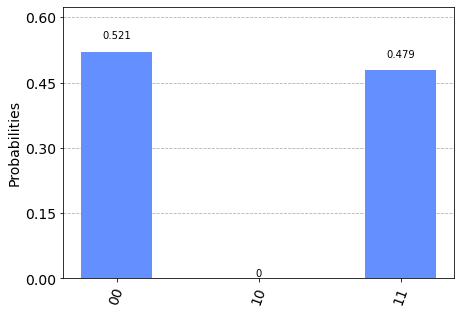

In [10]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(code, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Circuit with Error Correcting Code")
plot_histogram(result.get_counts(code))

### Test 2:
**Bit Flip - 5%**  
**Phase Flip - 5%**

Vanilla Circuit without Error Correction


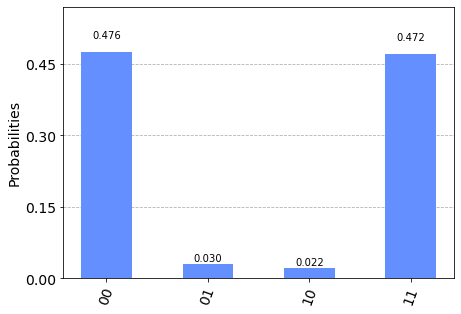

In [11]:
# Simulating the quantum circuit
phase_bit_flip = noise_model(phase_flip_prob = 0.05, bit_flip_prob = 0.05)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Vanilla Circuit without Error Correction")
plot_histogram(result.get_counts(circuit))

Circuit with Error Correcting Code


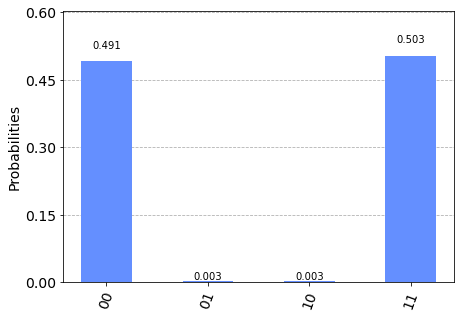

In [12]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(code, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Circuit with Error Correcting Code")
plot_histogram(result.get_counts(code))

### Test 3:
**Bit Flip - 10%**  
**Phase Flip - 10%**

Vanilla Circuit without Error Correction


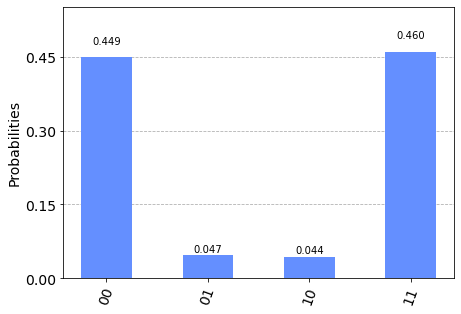

In [13]:
# Simulating the quantum circuit
phase_bit_flip = noise_model(phase_flip_prob = 0.1, bit_flip_prob = 0.1)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Vanilla Circuit without Error Correction")
plot_histogram(result.get_counts(circuit))

Circuit with Error Correcting Code


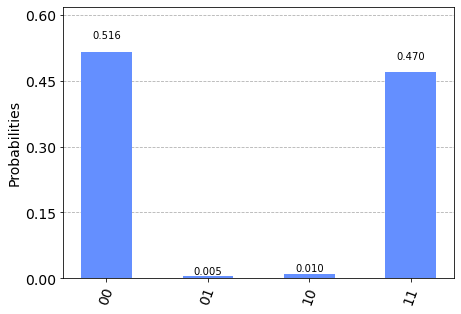

In [14]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(code, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Circuit with Error Correcting Code")
plot_histogram(result.get_counts(code))

### Test 4:
**Bit Flip - 30%**  
**Phase Flip - 30%**

Vanilla Circuit without Error Correction


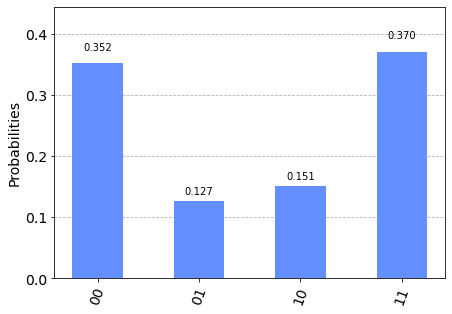

In [61]:
# Simulating the quantum circuit
phase_bit_flip = noise_model(phase_flip_prob = 0.30, bit_flip_prob = 0.30)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Vanilla Circuit without Error Correction")
plot_histogram(result.get_counts(circuit))

Circuit with Error Correcting Code


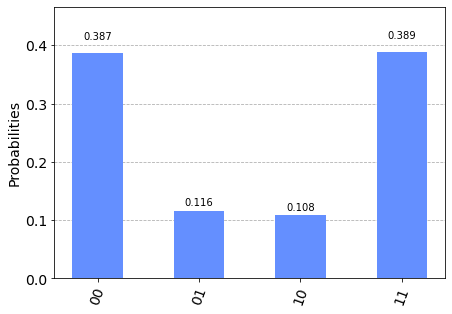

In [62]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(code, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Circuit with Error Correcting Code")
plot_histogram(result.get_counts(code))

### Test 5:
**Bit Flip - 40%**  
**Phase Flip - 40%**

Vanilla Circuit without Error Correction


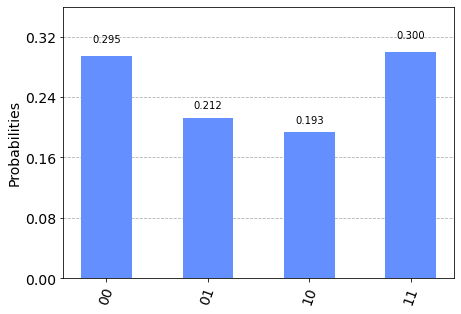

In [48]:
# Simulating the quantum circuit
phase_bit_flip = noise_model(phase_flip_prob = 0.40, bit_flip_prob = 0.40)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Vanilla Circuit without Error Correction")
plot_histogram(result.get_counts(circuit))

Circuit with Error Correcting Code


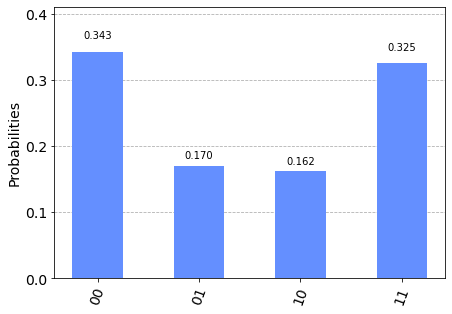

In [49]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(code, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Circuit with Error Correcting Code")
plot_histogram(result.get_counts(code))

### Test 6: Maximum Error - The gates $E_1$ and $E_2$ are never Identity
**Bit Flip - 50%**  
**Phase Flip - 50%**

Vanilla Circuit without Error Correction


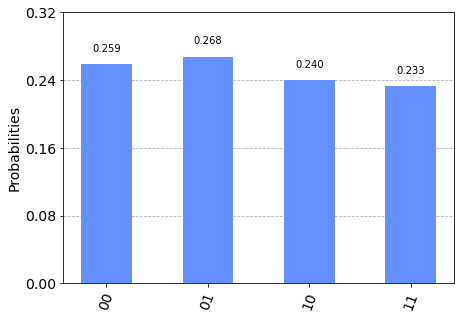

In [38]:
# Simulating the quantum circuit
phase_bit_flip = noise_model(phase_flip_prob = 0.50, bit_flip_prob = 0.50)
result = execute(circuit, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Vanilla Circuit without Error Correction")
plot_histogram(result.get_counts(circuit))

Circuit with Error Correcting Code


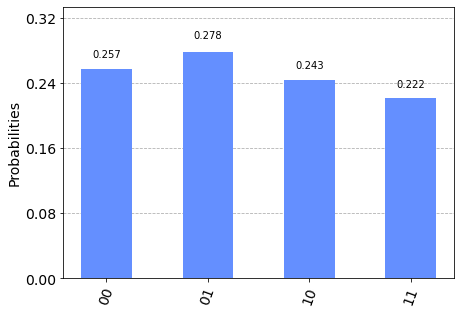

In [40]:
# Reusing the noise model from part 2.2 to compare performace of the Shor Code with the Vanilla Circuit
result = execute(code, backend = simulator, noise_model = phase_bit_flip).result()

# Plotting the Simulation results
print("Circuit with Error Correcting Code")
plot_histogram(result.get_counts(code))

From the above plots, we can infer that for low probabilities of an error occuring, the Shor Code corrects the error introduced. As the probabilty of error increases, the chances that an error occurs in more than one qubit (including ancilla qubits) is high, resulting in a wrong state at the output of the circuit even after applying the Error Correction Code. 

In Example 1, with error probabilities of 1%, the Code improved the probabilities of obtaining the correct state at the output.  

In Example 2, with error probabilities of 5%, the Code improved the probabilities of obtaining the correct state at the output.  

In Example 3, with error probabilities of 10%, the Code improved the probabilities of obtaining the correct state at the output.  

In Example 4, with error probabilities of 30%, the Code did a poor job of correcting the error. In fact, it increased the probability of getting a wrong result.  

In Example 5, with error probabilities of 40%, the Code did a poor job of correcting the error. There was no significant improvement in the reuslts.  

In Example 6, with error probabilities of 50%, the Code did not offer any improvement in correcting the error. All four measurement results are obtained with equal probabilities.   

## Conclusions

1. As the Total Error Probability increases, the relative improvement provided by the of the Error Correcting Code decreases. Here, I define the relative improvement as follows:  
$RI = \frac{\text{Error Probability in the Absence of a QECC} - \text{Error Probability in the presence of a QECC}}{\text{Error Probability in the Absence of a QECC}}$   

2. As the Total Error Probability increases beyond 50%, the improvement provided by the QECC is not very significant.  

3. When there is 100% probability of error, the QECC doesn't introduce any improvement as the Code assumes that the error is an actual gate in the circuit.  

## References

1. Qiskit Foundations - Coding with Qiskit: https://www.youtube.com/playlist?list=PLOFEBzvs-Vvp2xg9-POLJhQwtVktlYGbY
2. Qiskit Textbook on QEC: https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html
3. Quantum Noise in Qiskit: https://qiskit.org/documentation/apidoc/aer_noise.html
4. Intro to Error Correction: https://qiskit.org/learn/intro-qc-qh/
5. Wikipedia Page on QEC: https://en.wikipedia.org/wiki/Quantum_error_correction